In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pystan

In [2]:
def lor(f, f0, w, h):
    return h / (1.0 + 4.0 / w**2 * (f - f0)**2)

In [3]:
f = np.linspace(100,120,2000)
true = 1 + lor(f, 110.0, 0.5, 100.0)
data = true * (np.random.chisquare(2, size=len(f))/2)

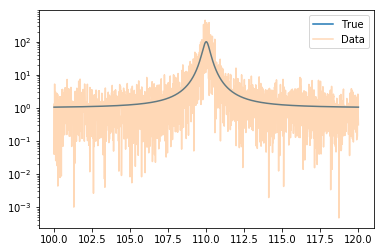

In [4]:
fig, ax = plt.subplots()
ax.plot(f, true, label='True')
ax.plot(f, data, alpha=0.3, label='Data')
ax.legend()
ax.set_yscale('log')

/home/davies/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/davies/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


(0.001, 1)

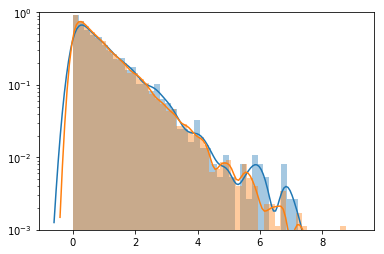

In [5]:
fig, ax = plt.subplots()
sns.distplot(data / true, ax=ax)
sns.distplot(np.random.chisquare(2, 10000)/2, ax=ax)
ax.set_yscale('log')
ax.set_ylim(0.001, 1)

In [6]:
code = '''
functions {
    real lor(real freq, real f0, real w, real h){
        return h / (1.0 + 4.0 / w^2 * (freq - f0)^2);
    }
}
data {
    int N;
    real f[N];
    real snr[N];
}
parameters {
    real freq;
    real ln_width;
    real ln_height;
}
transformed parameters {
    real width;
    real height;
    width = exp(ln_width);
    height = exp(ln_height);
}
model {
    real beta[N];
    for (i in 1:N){
        beta[i] = 1.0 / (1.0 + lor(f[i], freq, width, height));
    }
    snr ~ gamma(1, beta);
    freq ~ normal(110.0, 1.0);
    ln_width ~ normal(log(0.5), 0.3);
    ln_height ~ normal(log(100.0), 0.3);
}
'''
import pystan
sm = pystan.StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_71b528cf39c93eb6fe3973cfbb67800a NOW.


In [7]:
stan_data = {'N': len(f),
             'f': f, 
             'snr': data}
start = {'freq': 110.0}
nchains = 4
fit = sm.sampling(data=stan_data, iter=1000, chains=nchains, init=[start for n in range(nchains)])

/home/davies/.local/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [8]:
print(fit)

Inference for Stan model: anon_model_71b528cf39c93eb6fe3973cfbb67800a.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
freq      110.01  7.2e-4   0.02 109.97  110.0 110.01 110.03 110.06   1010    1.0
ln_width   -0.71  2.7e-3   0.08  -0.88  -0.77  -0.71  -0.66  -0.56    927    1.0
ln_height   4.76  4.6e-3   0.14   4.49   4.67   4.75   4.84   5.05    924    1.0
width       0.49  1.3e-3   0.04   0.41   0.47   0.49   0.52   0.57    931    1.0
height    117.52    0.56  16.96  89.18 106.23 115.73 126.93 156.03    905    1.0
lp__       -3383    0.05   1.27  -3387  -3384  -3383  -3383  -3382    703   1.01

Samples were drawn using NUTS at Tue Nov 20 10:54:24 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


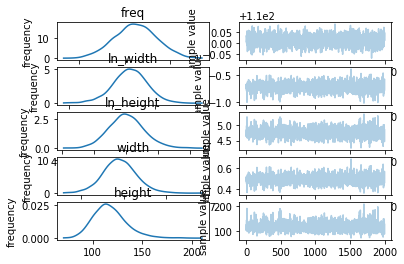

In [9]:
fit.plot()
plt.show()

In [14]:
fitvb = sm.vb(data=stan_data, output_samples=2000, eta=5, iter = 10000, tol_rel_obj=0.001)

/home/davies/.local/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [16]:
print(fitvb)

OrderedDict([('args', {'random_seed': '1506635220', 'chain_id': 1, 'init': b'random', 'init_radius': 2.0, 'enable_random_init': False, 'append_samples': False, 'sample_file': b'/tmp/tmpcfv8vkog/output.csv', 'method': 'VARIATIONAL', 'iter': 10000, 'grad_samples': 1, 'elbo_samples': 100, 'eval_elbo': 100, 'output_samples': 2000, 'eta': 5.0, 'adapt_engaged': True, 'adapt_iter': 50, 'tol_rel_obj': 0.001, 'algorithm': 'MEANFIELD'}), ('inits', [-1.825315824233536, 1.4018769080570963, -1.344514615660653, 4.062818351602956, 0.26066620045022665]), ('sampler_params', [[109.99910649578639, 109.98762159484865, 109.99789876394865, 110.03306083729592, 109.98460433122092, 109.9557694453003, 110.01419989872716, 109.99026586871815, 109.99115323502814, 109.96099698810137, 109.9817160330437, 110.00311756757428, 110.04572732405155, 109.99260725114667, 110.00263372413708, 109.98664367975024, 109.96422059638648, 109.98370686698208, 109.98240126513913, 109.99950555139884, 110.01748009014645, 110.039780471613

In [17]:
print(fitvb['mean_pars'])

[109.99910649578639, -0.6617696880935009, 4.78413057698309, 0.5159374776981837, 119.59733719144361]


In [18]:
print(fit)

Inference for Stan model: anon_model_71b528cf39c93eb6fe3973cfbb67800a.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
freq      110.01  7.2e-4   0.02 109.97  110.0 110.01 110.03 110.06   1010    1.0
ln_width   -0.71  2.7e-3   0.08  -0.88  -0.77  -0.71  -0.66  -0.56    927    1.0
ln_height   4.76  4.6e-3   0.14   4.49   4.67   4.75   4.84   5.05    924    1.0
width       0.49  1.3e-3   0.04   0.41   0.47   0.49   0.52   0.57    931    1.0
height    117.52    0.56  16.96  89.18 106.23 115.73 126.93 156.03    905    1.0
lp__       -3383    0.05   1.27  -3387  -3384  -3383  -3383  -3382    703   1.01

Samples were drawn using NUTS at Tue Nov 20 10:54:24 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
